In [1]:
from datetime import datetime

import humanize
import numpy as np
import pandas as pd
import pickle
import time
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
from tabulate import tabulate


%matplotlib inline

In [2]:
df = pd.read_csv('./data/CT-clean.csv', header=0)

D:\AppData\Local\conda\conda\envs\kaggle\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Drop columns that clearly should be dropped

drop_cols = [
    'county_fips',
    'driver_age',
    'driver_race_raw',
    'fine_grained_location',
    'id',
    'is_arrested',
    'officer_id',
    'police_department',
    'search_type_raw',
    'search_type',
    'state',
]

df.drop(drop_cols, axis=1, inplace=True)

In [4]:
df.shape

(318669, 13)

In [5]:
df.isnull().sum()

stop_date              0
stop_time            222
location_raw          41
county_name           42
driver_gender          0
driver_age_raw         0
driver_race            0
violation_raw          0
violation              0
search_conducted       0
contraband_found       0
stop_outcome        5356
stop_duration          0
dtype: int64

In [6]:
# Drop empty stop_outcome and county_name/county_fips rows

df.dropna(subset=['stop_outcome', 'county_name'], axis=0, inplace=True)

In [7]:
df.shape

(313274, 13)

In [8]:
df.isnull().sum()

stop_date             0
stop_time           220
location_raw          0
county_name           0
driver_gender         0
driver_age_raw        0
driver_race           0
violation_raw         0
violation             0
search_conducted      0
contraband_found      0
stop_outcome          0
stop_duration         0
dtype: int64

#### Outcomes by Violations

Two columns, **`violation`** and **`violations_raw`**, provide information about the related violation(s) involved in a traffic stop outcome.  Unfortunately, these columns suffer from repetitive values and inconsistent data entry issues.  For example, some values are phrased differently yet have the same meaning.  I will need to settle on a standard value for these duplicate values and perform one-hot encoding for each class value.

In [9]:
def normalize_violation(violation):
    """Normalize violation values
    """
    if violation == 'defective lights':
        return 'lights'
    elif violation == 'equipment violation':
        return 'equipment'
    elif violation == 'other/error':
        return 'other'
    elif violation == 'registration/plates':
        return 'registration'
    elif violation == 'seat belt':
        return 'seatbelt'
    elif violation == 'speed related':
        return 'speeding'
    elif violation == 'stop sign/light' or violation == 'stop sign':
        return 'bad_stop'
    return violation.replace(' ', '_')


def merge_violations(violations):
    """Merge violation and violation_raw columns
    """
    merged = []
    tokens = violations.lower().split(',')
    return list(set([normalize_violation(violation) for violation in tokens]))
    

def onehot_encode_violations(arr_violations):
    row = np.zeros(len(violations))
    for v in arr_violations:
        row[violations.index(v)] = 1
    return row


violations = []

for violation in list(df.violation.unique()) + list(df.violation_raw.unique()):
    tokens = violation.lower().split(',')
    violations.extend([normalize_violation(token) for token in tokens])

violations = sorted(set(violations))

merged = df[['violation_raw', 'violation']].apply(lambda x: ','.join(x), axis=1).apply(merge_violations)

violation_col_headers = ['violation_{}'.format(violation.replace(' ', '_')) for violation in violations]

df_violations = merged.apply(onehot_encode_violations).apply(lambda x: pd.Series(x, dtype=int))
df_violations.columns = violation_col_headers

In [10]:
# Append one-hot encoded violations
df = pd.concat([df, df_violations], axis=1)

# Remove records with age less than 15
weird_ages_rows = df[df["driver_age_raw"] < 15]['driver_age_raw']
df.drop(index=weird_ages_rows.index, inplace=True)

# Fill in empty **`stop_time`** with median value
populated = df[df.stop_time.notnull()]['stop_time'].sort_values()
median_stop_time = populated.iloc[populated.shape[0] // 2]
df['stop_time'].fillna(median_stop_time, inplace=True)

In [11]:
# df.shape

In [12]:
# Categorize stop_time into time-of-day: "morning, afternoon, evening, small hours"
def day_period(time_str):
    hour = time_str.hour
    if hour >= 0 and hour < 6:
        return 'Small Hours'
    elif hour >= 6 and hour < 12:
        return 'Morning'
    elif hour >= 12 and hour < 18:
        return 'Afternoon'
    else:
        return 'Evening'

df['day_period'] = pd.to_datetime(df['stop_time']).apply(day_period)


In [13]:
# df.shape

In [14]:
# Categorize stop_date by season
def season(stop_date):
    month = datetime.strptime(stop_date, '%Y-%m-%d').month
    if month >= 3 and month < 6:
        return 'Spring'
    elif month >= 6 and month < 9:
        return 'Summer'
    elif month >= 9 and month < 12:
        return 'Fall'
    return 'Winter'

df['season'] = df['stop_date'].apply(season)

In [15]:
# Transform driver_gender to binary
df['is_male'] = df['driver_gender'].apply(lambda x: 1 if x == 'M' else 0)

In [16]:
# Experiment: See whether labelencoding location_raw improves performance
from sklearn.preprocessing import LabelEncoder

le_location_raw = LabelEncoder()
le_county_name = LabelEncoder()
le_driver_race = LabelEncoder()
le_stop_duration = LabelEncoder()
le_day_period = LabelEncoder()
le_season = LabelEncoder()

df['location_raw'] = le_location_raw.fit_transform(df['location_raw'])
df['county_name'] = le_county_name.fit_transform(df['county_name'])
df['driver_race'] = le_driver_race.fit_transform(df['driver_race'])
df['stop_duration'] = le_stop_duration.fit_transform(df['stop_duration'])
df['day_period'] = le_day_period.fit_transform(df['day_period'])
df['season'] = le_season.fit_transform(df['season'])


In [17]:
# df.shape

In [18]:
# Drop columns no longer needed due to normalization
drop_cols = [
    'driver_gender',
#     'county_name',
#     'location_raw',
#     'officer_id',
    'stop_date',
    'stop_time',
    'violation_raw',
    'violation',
]

df.drop(drop_cols, axis=1, inplace=True)

In [19]:
# df.shape

In [20]:
# Convert booleans to 0 and 1
df['search_conducted'] = df['search_conducted'].apply(lambda x: int(x))
df['contraband_found'] = df['contraband_found'].apply(lambda x: int(x))

In [21]:
# Normalize driver_age
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() # default=(0, 1)
features_transformed = pd.DataFrame(data=df)
features_transformed['driver_age_raw'] = scaler.fit_transform(features_transformed['driver_age_raw'].reshape(-1, 1))
# features_transformed

D:\AppData\Local\conda\conda\envs\kaggle\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
D:\AppData\Local\conda\conda\envs\kaggle\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


In [22]:
features_transformed.shape

(313129, 26)

In [23]:
features_transformed.drop_duplicates(inplace=True)

In [24]:
# features_transformed.shape

In [25]:
# Prefix officer id numbers as dtype is object and get_dummies() creates some duplicate columns
# features_transformed['officer_id'] = le.fit_transform(features_transformed['officer_id'].apply(lambda x: 'no_{}'.format(x)))


In [26]:
# One-hot encode categorical variables
# cols_to_encode = [
# #     'location_raw',
#     'county_name',
#     'driver_race',
# #     'officer_id',
#     'stop_duration',
#     'day_period',
#     'season',
# ]
# final_features = pd.get_dummies(features_transformed, columns=cols_to_encode)
# final_features.columns.values

In [27]:
final_features = features_transformed

In [28]:
# final_features.shape

In [29]:
from datetime import datetime

timestamp = datetime.now().strftime('%Y%m%d%H%M%S')

# non_oversampled = final_features.copy(deep=True)
# non_oversampled_outcomes = non_oversampled.pop('stop_outcome')

# non_oversampled.to_pickle('./final_features-{}-non_oversampled.pkl'.format(timestamp))
# non_oversampled_outcomes.to_pickle('./labels-{}-non_oversampled.pkl'.format(timestamp))
# print('timestamp = {}'.format(timestamp))

An additional preprocessing step I took was oversampling the data to address the extreme imbalance in the traffic stop outcomes.  I computed a multiplier for each non-"Ticket" outcome value:

In [30]:
tickets = final_features.loc[final_features['stop_outcome'] == 'Ticket']
arrests = final_features.loc[final_features['stop_outcome'] == 'Arrest']
summons = final_features.loc[final_features['stop_outcome'] == 'Summons']
ww = final_features.loc[final_features['stop_outcome'] == 'Written Warning']
vw = final_features.loc[final_features['stop_outcome'] == 'Verbal Warning']

In [31]:
multiplier_arrests = tickets.shape[0] // arrests.shape[0]
multiplier_summons = tickets.shape[0] // summons.shape[0]
multiplier_ww = tickets.shape[0] // ww.shape[0]
multiplier_vw = tickets.shape[0] // vw.shape[0]
# print('Arrests: {}\nSummons: {}\nWW: {}\nVW: {}'.format(multiplier_arrests, multiplier_summons, multiplier_ww, multiplier_vw))
# Output:
# Arrests: 26
# Summons: 15
# WW: 7
# VW: 4


| Outcome         | Multiplier |
|:----------------|:----------:|
| Arrest          |     26     |
| Summons         |     15     |
| Written Warning |      7     |
| Verbal Warning  |      4     |

In [32]:
oversampled = final_features.append([arrests] * multiplier_arrests, ignore_index=True)
oversampled = oversampled.append([summons] * multiplier_summons, ignore_index=True)
oversampled = oversampled.append([ww] * multiplier_ww, ignore_index=True)
oversampled = oversampled.append([vw] * multiplier_vw, ignore_index=True)
# oversampled.shape

In [33]:
from datetime import datetime

timestamp = datetime.now().strftime('%Y%m%d%H%M%S')

oversampled.to_pickle('./oversampled-labelencoded_test{}.pkl'.format(timestamp))
# outcomes.to_pickle('./labels-{}-labelencoded_test.pkl'.format(timestamp))
print('timestamp = {}'.format(timestamp))

timestamp = 20180515134342


In [34]:
# Extract target labels
outcomes = oversampled.pop('stop_outcome')

I then replicated the associated rows by their multipliers, and the more balanced resulting distribution of outcomes is illustrated in the following bar chart:

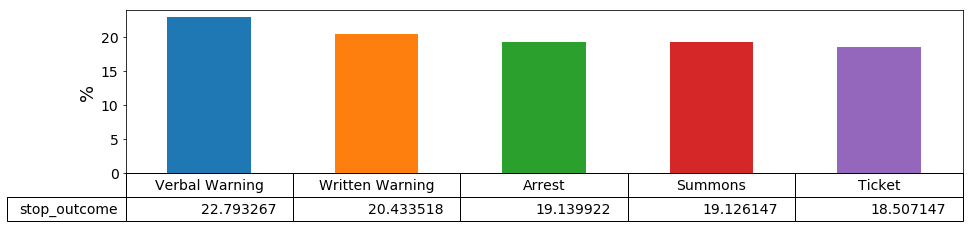

In [35]:
outcome_breakdown = outcomes.value_counts(normalize=True).mul(100).apply(lambda x: float('{:.6f}'.format(x))).plot.bar(figsize=(15, 3), table=True, fontsize=14)
outcome_breakdown.axes.get_xaxis().set_visible(False)
outcome_breakdown.axes.set_ylabel('%', fontsize=18)
outcome_breakdown.tables[0].auto_set_font_size(False)
outcome_breakdown.tables[0].set_fontsize(14)
outcome_breakdown.tables[0].scale(1, 2)

In [36]:
oversampled.shape

(1009048, 25)

In [37]:
oversampled.columns.values

array(['location_raw', 'county_name', 'driver_age_raw', 'driver_race',
       'search_conducted', 'contraband_found', 'stop_duration',
       'violation_bad_stop', 'violation_cell_phone',
       'violation_display_of_plates', 'violation_equipment',
       'violation_license', 'violation_lights',
       'violation_moving_violation', 'violation_other',
       'violation_registration', 'violation_safe_movement',
       'violation_seatbelt', 'violation_speeding',
       'violation_suspended_license', 'violation_traffic_control_signal',
       'violation_window_tint', 'day_period', 'season', 'is_male'],
      dtype=object)

In [38]:
from datetime import datetime

timestamp = datetime.now().strftime('%Y%m%d%H%M%S')

# oversampled.to_pickle('./final_features-labelencoded_test{}.pkl'.format(timestamp))
# outcomes.to_pickle('./labels-{}-labelencoded_test.pkl'.format(timestamp))
print('timestamp = {}'.format(timestamp))

timestamp = 20180515134343


In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

le_outcomes = LabelEncoder()

oversampled = pickle.load(open('oversampled-labelencoded_test20180515105408.pkl', 'rb'))
oversampled['stop_outcome'] = le_outcomes.fit_transform(oversampled['stop_outcome'])

oversampled = shuffle(oversampled, random_state=0)
outcomes = oversampled.pop('stop_outcome')

In [1]:
# Take out 5% of data for final final testing; shuffle first
lop_off_pct = .05
lop_off_idx = round(oversampled.shape[0] * lop_off_pct)
print('lop_off_idx = {}'.format(lop_off_idx))

final_test_features = oversampled[:lop_off_idx]
final_test_outcomes = outcomes[:lop_off_idx]

oversampled = oversampled[lop_off_idx:]
outcomes = outcomes[lop_off_idx:]

NameError: name 'outcomes' is not defined

In [3]:
from sklearn.model_selection import train_test_split

# # Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(oversampled, 
                                                    outcomes, 
                                                    test_size=0.2, 
                                                    random_state=0)


In [53]:
clf1 = RandomForestClassifier(n_jobs=8, verbose=3, random_state=0)
clf2 = GaussianNB()
clf3 = DecisionTreeClassifier(random_state=0)
clf4 = GradientBoostingClassifier(verbose=3, random_state=0)

eclf = VotingClassifier(estimators=[
        ('rf', clf1), ('gnb', clf2), ('dt', clf3), ('gb', clf4)],
        voting='soft')
eclf = eclf.fit(X_train, y_train)
print('eclf score: {}'.format(eclf.score(X_test, y_test)))

building tree 1 of 10building tree 2 of 10building tree 3 of 10building tree 4 of 10building tree 5 of 10building tree 6 of 10building tree 7 of 10building tree 8 of 10







building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    2.7s remaining:    6.4s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    2.8s remaining:    1.1s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    4.0s finished


      Iter       Train Loss   Remaining Time 
         1     1250488.2855            7.09m
         2     1213922.7555            7.04m
         3     1184023.0160            6.96m
         4     1159762.9953            6.87m
         5     1139437.7825            6.81m
         6     1122359.8648            6.74m
         7     1108090.7823            6.65m
         8     1095242.0953            6.57m
         9     1084593.4635            6.49m
        10     1075614.4722            6.38m
        11     1067488.4778            6.30m
        12     1060443.9464            6.22m
        13     1054320.2715            6.15m
        14     1049155.1351            6.06m
        15     1044216.5068            6.00m
        16     1040172.8483            5.92m
        17     1036683.3920            5.81m
        18     1033255.4860            5.73m
        19     1030436.8449            5.65m
        20     1027656.8533            5.57m
        21     1025305.0790            5.48m
        2

[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.1s finished


eclf score: 0.9311035132054903


D:\AppData\Local\conda\conda\envs\kaggle\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [154]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
print('GaussianNB: {}'.format(gnb.score(X_test, y_test)))

GaussianNB: 0.3754381389526393


In [46]:
gbc = GradientBoostingClassifier(random_state=0)
gbc.fit(X_train, y_train)
print('GradientBoostingClassifier: {}'.format(gbc.score(X_test, y_test)))

GradientBoostingClassifier: 0.5131410732867548


In [155]:
dtc = DecisionTreeClassifier(random_state=0)
dtc.fit(X_train, y_train)
print('DecisionTreeClassifier: {}'.format(dtc.score(X_test, y_test)))

DecisionTreeClassifier: 0.9172804089296891


In [156]:
dtc2 = DecisionTreeClassifier(random_state=0, splitter="random", max_features="log2")
dtc2.fit(X_train, y_train)
print('DecisionTreeClassifier: {}'.format(dtc2.score(X_test, y_test)))

DecisionTreeClassifier: 0.919017316920509


In [153]:
print(classification_report(dtc2.predict(X_test), y_test))

ValueError: Mix of label input types (string and number)

```
              precision    recall  f1-score   support
Arrest             1.00      0.97      0.98     40127
Summons            1.00      0.96      0.98     40057
Ticket             0.65      0.99      0.78     24189
Verbal Warning     0.96      0.86      0.91     51690
Written Warning    0.98      0.89      0.93     45747

avg / total        0.94      0.92      0.93    201810
```


In [157]:
rfc = RandomForestClassifier(random_state=0, n_jobs=8)
rfc.fit(X_train, y_train)
print('RandomForestClassifier: {}'.format(rfc.score(X_test, y_test)))

RandomForestClassifier: 0.9263770081368663


# XGBoost

In [141]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import matplotlib
# matplotlib.use('Agg')
from matplotlib import pyplot


In [143]:
xg_train = xgb.DMatrix(X_train.values, label=y_train)
xg_test = xgb.DMatrix(X_test.values, label=y_test)
xg_test_2 = xgb.DMatrix(final_test_features.values, label=le_outcomes.fit_transform(final_test_outcomes))

In [144]:
params = {
    'objective': 'multi:softmax',
    'learning_rate': 0.0983,
    'max_depth': 19,
    'silent': 0,
    'nthread': 8,
#     'num_class': 45,
#     'predictor': 'gpu_predictor',
#     'max_bin': 512,
    'tree_method': 'gpu_hist',
#     'alpha': 0.8,
#     'gamma': 10.0,
    'subsample': 0.9,
#     'lambda': 0.9,,
#     'colsample_bytree': 0.9,
#     'colsample_bylevel': 0.3,
#     'scale_pos_weight': 0.1,
#     'updater': 'grow_histmaker,refresh,prune',
#     'grow_policy': 'lossguide',
#     'max_leaves': 20000,
#     'max_bin': 1024,
#     'base_score': 1.0,
#     'eval_metric': 'merror',
#     'max_delta_step': 8,
}

params['num_class'] = len(list(final_features.columns.values))


In [145]:
watchlist = [(xg_train, 'train'), (xg_test, 'test')]
num_round = 10000
# num_round = 5

bst = xgb.train(params=params, dtrain=xg_train, num_boost_round=num_round, evals=watchlist, early_stopping_rounds=50)
# bst = xgb.train(params=params, dtrain=xg_train, num_boost_round=num_round, evals=watchlist)

[0]	train-merror:0.341495	test-merror:0.359853
Multiple eval metrics have been passed: 'test-merror' will be used for early stopping.

Will train until test-merror hasn't improved in 50 rounds.
[1]	train-merror:0.295788	test-merror:0.31764
[2]	train-merror:0.271844	test-merror:0.296531
[3]	train-merror:0.25428	test-merror:0.279945
[4]	train-merror:0.241173	test-merror:0.267223
[5]	train-merror:0.231698	test-merror:0.258262
[6]	train-merror:0.21967	test-merror:0.248232
[7]	train-merror:0.211022	test-merror:0.240783
[8]	train-merror:0.201888	test-merror:0.2331
[9]	train-merror:0.194839	test-merror:0.226888
[10]	train-merror:0.188762	test-merror:0.221198
[11]	train-merror:0.182958	test-merror:0.215815
[12]	train-merror:0.177578	test-merror:0.211392
[13]	train-merror:0.172997	test-merror:0.207443
[14]	train-merror:0.169081	test-merror:0.203682
[15]	train-merror:0.165684	test-merror:0.200516
[16]	train-merror:0.162464	test-merror:0.197449
[17]	train-merror:0.159482	test-merror:0.19445
[18]	

In [146]:
pred = bst.predict(xg_test)

In [147]:
error_rate = np.sum(pred != y_test) / y_test.shape[0]
print('Test error using softmax = {}'.format(error_rate))

Test error using softmax = 0.06259649488837889


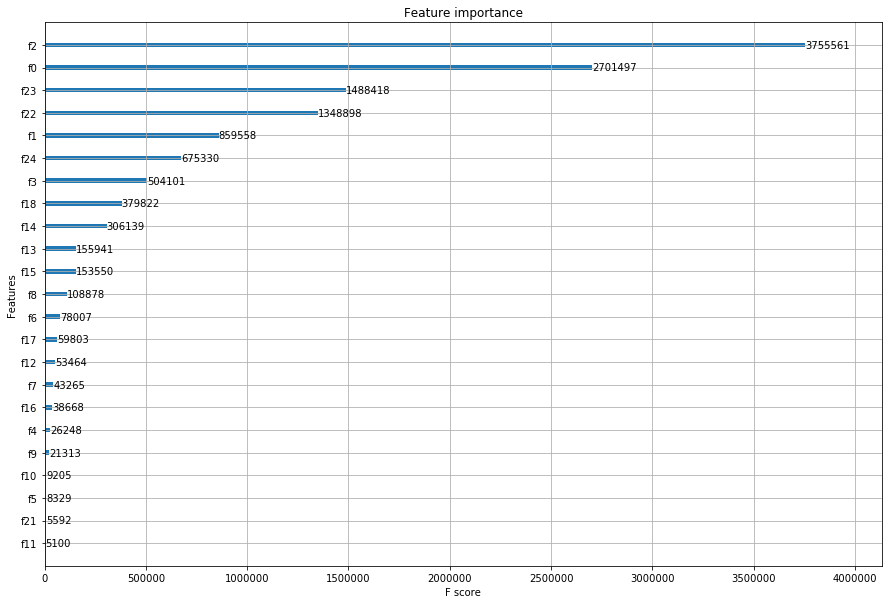

In [148]:
ax = xgb.plot_importance(bst)
fig = ax.figure
fig.set_size_inches(15, 10)

In [149]:
for idx, c in enumerate(oversampled.columns.values):
    print('{}: {}'.format(idx, c))

0: location_raw
1: county_name
2: driver_age_raw
3: driver_race
4: search_conducted
5: contraband_found
6: stop_duration
7: violation_bad_stop
8: violation_cell_phone
9: violation_display_of_plates
10: violation_equipment
11: violation_license
12: violation_lights
13: violation_moving_violation
14: violation_other
15: violation_registration
16: violation_safe_movement
17: violation_seatbelt
18: violation_speeding
19: violation_suspended_license
20: violation_traffic_control_signal
21: violation_window_tint
22: day_period
23: season
24: is_male


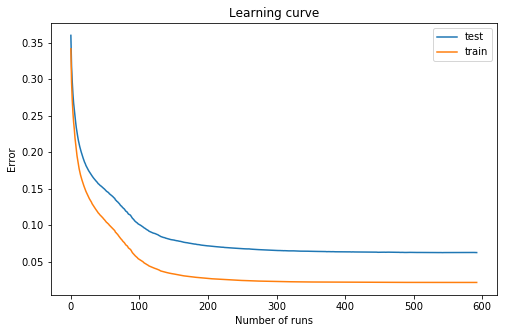

In [151]:
error_results = {
    'train': [],
    'test': [],
}

logfile = 'runs/201805111748-oversampled-0.0626-error-592-run.log'
with open(logfile, 'r') as f:
    for line in f:
        tokens = line.strip().split('\t')
        error_results['train'].append(float(tokens[1].split(':')[1]))
        error_results['test'].append(float(tokens[2].split(':')[1]))

df_errors = pd.DataFrame(error_results)

learning_curve = df_errors.plot.line(title='Learning curve', figsize=(8,5))
learning_curve.set_xlabel('Number of runs')
learning_curve.set_ylabel('Error')

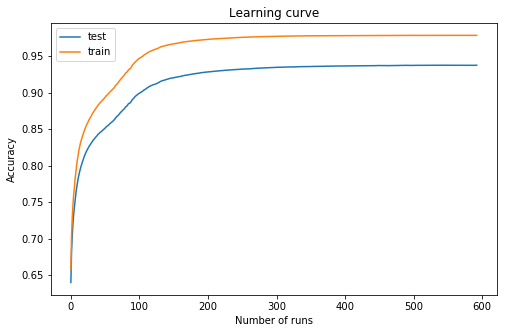

In [152]:
df_accuracy = df_errors.copy()
df_accuracy_processed = df_accuracy.mul(-1).add(1)

learning_curve = df_accuracy_processed.plot.line(title='Learning curve', figsize=(8,5))
learning_curve.set_xlabel('Number of runs')
learning_curve.set_ylabel('Accuracy')

# GridSearchCV

## RandomForestClassifier

In [14]:
params_rfc = {
#     'class_weight': None,
    'n_estimators': [10, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 19],
    'max_features': [None, 'sqrt', 'log2'],
#     'min_impurity_split': [0.0000001],

#     'min_samples_split': [2, 5, 10], 
#     'min_samples_leaf':[1, 2, 4],

#     'min_weight_fraction_leaf': [0],

#     'max_leaf_nodes': [None, 100, 1000, 2000],
    'n_jobs': [8],
    'random_state': [0],
    'verbose': [3],
}

rfc = RandomForestClassifier()

clf = RandomizedSearchCV(rfc, params_rfc, scoring='accuracy', n_jobs=8, cv=5, verbose=3)
clf.fit(X_train, y_train)

timestamp = datetime.now().strftime('%Y%m%d%H%M%S')
pickle.dump(clf, open('{}-randomforestclassifier-clf.pkl'.format(timestamp), 'wb'))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=sqrt, max_depth=None, criterion=gini 
[CV] verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=sqrt, max_depth=None, criterion=gini 
building tree 2 of 10
building tree 6 of 10
building tree 3 of 10
building tree 7 of 10
building tree 5 of 10
building tree 1 of 10
building tree 8 of 10
building tree 4 of 10
[CV] verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=sqrt, max_depth=None, criterion=gini 
[CV] verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=sqrt, max_depth=None, criterion=gini 
building tree 4 of 10
building tree 2 of 10
building tree 1 of 10
building tree 3 of 10
building tree 7 of 10
building tree 6 of 10
building tree 8 of 10
building tree 5 of 10
[CV] verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=sqrt, max_depth=None, criterion=gini 
[CV] verbose=3, random_state=0, n_job

[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    8.1s remaining:   19.0s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:   10.1s remaining:    4.3s


building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:   13.2s remaining:   30.7s


building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:   15.1s remaining:    6.5s


building tree 9 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:   14.4s remaining:   33.7s
[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:   14.9s remaining:   34.7s


building tree 10 of 10


[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:   15.3s remaining:    6.6s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:   15.4s remaining:    6.6s
[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:   14.9s remaining:   34.8s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:   15.4s remaining:    6.6s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:   19.0s finished
[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    0.7s remaining:    1.7s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:   22.6s finished
[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    2.2s remaining:    5.2s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    2.4s remaining:    1.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:   22.5s finished
[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    0.6s remaining:    1.4s


[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=sqrt, max_depth=None, criterion=gini, score=0.915812423737527, total=  20.8s


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    1.1s finished


[CV] verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=None, max_depth=None, criterion=gini 


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    2.4s remaining:    5.7s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    2.7s remaining:    1.2s


building tree 3 of 10
building tree 2 of 10
building tree 8 of 10
building tree 1 of 10
building tree 5 of 10
building tree 7 of 10
building tree 6 of 10
building tree 4 of 10


[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    2.9s remaining:    6.8s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    3.1s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    3.0s remaining:    7.1s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    3.2s remaining:    1.4s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    5.2s finished
[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    3.2s remaining:    7.6s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    3.4s remaining:    1.5s


[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=sqrt, max_depth=None, criterion=gini, score=0.9164312967642833, total=  24.8s
[CV] verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=None, max_depth=None, criterion=gini 


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    5.6s finished


[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=sqrt, max_depth=None, criterion=gini, score=0.9166356969426689, total=  25.6s


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    5.6s finished


[CV] verbose=3, random_state=0, n_jobs=8, n_estimators=100, max_features=None, max_depth=19, criterion=entropy 
building tree 9 of 10
[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=sqrt, max_depth=None, criterion=gini, score=0.9163259997026907, total=  25.9s
building tree 8 of 10
building tree 5 of 10
building tree 2 of 10
building tree 3 of 10
building tree 1 of 10


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    5.6s finished


building tree 6 of 10
building tree 7 of 10
[CV] verbose=3, random_state=0, n_jobs=8, n_estimators=100, max_features=None, max_depth=19, criterion=entropy 
building tree 4 of 10
building tree 9 of 10
[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=sqrt, max_depth=None, criterion=gini, score=0.9169810152064171, total=  25.9s
[CV] verbose=3, random_state=0, n_jobs=8, n_estimators=100, max_features=None, max_depth=19, criterion=entropy 
building tree 10 of 10
building tree 10 of 10


[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:   32.4s remaining:  1.3min


building tree 6 of 100
building tree 8 of 100
building tree 2 of 100
building tree 3 of 100
building tree 7 of 100


[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:   31.5s remaining:  1.2min


building tree 5 of 100
building tree 4 of 100
building tree 1 of 100


[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:   33.0s remaining:   14.2s


building tree 9 of 10


[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:   32.2s remaining:   13.8s


building tree 10 of 10
building tree 2 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 1 of 100
building tree 5 of 100
building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:   31.4s remaining:  1.2min


building tree 4 of 100
building tree 5 of 100
building tree 3 of 100
building tree 2 of 100
building tree 6 of 100
building tree 7 of 100
building tree 1 of 100
building tree 8 of 100


[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:   32.0s remaining:   13.7s


building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:   31.4s remaining:  1.2min
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:   32.8s remaining:   14.1s


building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:   30.5s remaining:  1.2min


building tree 9 of 100


[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:   31.0s remaining:   13.3s


building tree 10 of 100
building tree 9 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 11 of 100
building tree 13 of 100
building tree 12 of 100
building tree 14 of 100
building tree 13 of 100
building tree 15 of 100


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:  1.0min finished


building tree 16 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 14 of 100
building tree 15 of 100


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:  1.0min finished
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:  1.1min finished
[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    0.7s remaining:    1.7s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.8s remaining:    0.3s


building tree 16 of 100
building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    0.6s remaining:    1.5s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.7s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    0.7s remaining:    1.7s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    2.7s remaining:    6.3s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    2.8s remaining:    1.2s
[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    2.7s remaining:    6.4s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    2.8s remaining:    1.2s
[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    2.8s remaining:    6.6s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    2.9s remaining

[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=None, max_depth=None, criterion=gini, score=0.9119902383429959, total= 1.1min
[CV] verbose=3, random_state=0, n_jobs=8, n_estimators=100, max_features=None, max_depth=19, criterion=entropy 


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    4.7s finished
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    4.8s finished


[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=None, max_depth=None, criterion=gini, score=0.913693573162876, total= 1.1min
[CV] verbose=3, random_state=0, n_jobs=8, n_estimators=100, max_features=None, max_depth=19, criterion=entropy 
[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=None, max_depth=None, criterion=gini, score=0.9122199580053144, total= 1.1min
[CV] verbose=3, random_state=0, n_jobs=8, n_estimators=100, max_features=sqrt, max_depth=19, criterion=gini 
building tree 6 of 100
building tree 5 of 100
building tree 8 of 100
building tree 2 of 100
building tree 3 of 100
building tree 7 of 100
building tree 4 of 100
building tree 1 of 100
building tree 7 of 100
building tree 1 of 100
building tree 4 of 100
building tree 5 of 100
building tree 8 of 100
building tree 3 of 100
building tree 2 of 100
building tree 6 of 100
building tree 3 of 100
building tree 2 of 100
building tree 6 of 100
building tree 1 of 100
building tree 4 of

[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:  1.0min finished


building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    0.9s remaining:    2.2s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    1.0s remaining:    0.4s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    1.7s finished


building tree 17 of 100
building tree 17 of 100
building tree 18 of 100
building tree 18 of 100


[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    3.4s remaining:    7.8s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    3.4s remaining:    1.5s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:  1.0min finished


building tree 17 of 100
building tree 19 of 100
building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    0.8s remaining:    1.9s


building tree 20 of 100


[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.8s remaining:    0.4s


building tree 21 of 100
building tree 22 of 100
building tree 18 of 100
building tree 19 of 100
building tree 21 of 100


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    1.6s finished


building tree 23 of 100


[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:  1.1min


building tree 24 of 100
building tree 22 of 100
building tree 20 of 100


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    6.7s finished


building tree 21 of 100
[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=None, max_depth=None, criterion=gini, score=0.9121512809077845, total= 1.1min
building tree 22 of 100
[CV] verbose=3, random_state=0, n_jobs=8, n_estimators=100, max_features=sqrt, max_depth=19, criterion=gini 
building tree 23 of 100
building tree 23 of 100


[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:  1.1min


building tree 24 of 100
building tree 17 of 100
building tree 24 of 100


[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:  1.1min


building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    3.4s remaining:    7.8s


building tree 23 of 100


[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    3.5s remaining:    1.5s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   25.8s


building tree 24 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 1 of 100
building tree 8 of 100


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    6.9s finished


[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=None, max_depth=None, criterion=gini, score=0.912948682213757, total= 1.1min
[CV] verbose=3, random_state=0, n_jobs=8, n_estimators=100, max_features=sqrt, max_depth=19, criterion=gini 
building tree 2 of 100
building tree 5 of 100
building tree 3 of 100
building tree 4 of 100
building tree 1 of 100
building tree 7 of 100
building tree 8 of 100
building tree 6 of 100
building tree 25 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 9 of 100
building tree 26 of 100
building tree 10 of 100
building tree 14 of 100
building tree 27 of 100
building tree 28 of 100
building tree 11 of 100
building tree 15 of 100
building tree 16 of 100
building tree 12 of 100
building tree 29 of 100
building tree 13 of 100
building tree 14 of 100
building tree 9 of 100
building tree 30 of 100
building tree 15 of 100
building tree 16 of 100
building

[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   30.8s


building tree 24 of 100
building tree 25 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 26 of 100
building tree 25 of 100
building tree 17 of 100
building tree 26 of 100
building tree 28 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 27 of 100
building tree 29 of 100
building tree 21 of 100
building tree 30 of 100
building tree 22 of 100
building tree 27 of 100
building tree 31 of 100
building tree 32 of 100
building tree 28 of 100
building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   30.7s


building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 41 of 100
building tree 31 of 100
building tree 32 of 100
building tree 32 of 100
building tree 42 of 100
building tree 25 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 26 of 100
building tree 46 of 100
building tree 27 of 100
building tree 47 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 48 of 100
building tree 31 of 100
building tree 32 of 100
building tree 25 of 100
building tree 27 of 100
building tree 26 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 17 of 100
building tree 49 of 100
building tree 18 of 100
building tree 17 of 100
building tree 19 of 100
building tree 18 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22

[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:  1.4min


building tree 24 of 100
building tree 19 of 100
building tree 20 of 100
building tree 33 of 100
building tree 53 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:  1.4min


building tree 24 of 100
building tree 37 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 57 of 100
building tree 40 of 100
building tree 58 of 100
building tree 59 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 45 of 100
building tree 63 of 100
building tree 64 of 100
building tree 46 of 100
building tree 47 of 100
building tree 33 of 100
building tree 48 of 100
building tree 34 of 100
building tree 33 of 100
building tree 41 of 100
building tree 34 of 100
building tree 42 of 100
building tree 35 of 100
building tree 33 of 100
building tree 43 of 100
building tree 36

[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  3.2min finished


building tree 92 of 100
building tree 49 of 100
building tree 93 of 100


[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.1s


building tree 94 of 100
building tree 95 of 100
building tree 89 of 100
building tree 96 of 100
building tree 50 of 100
building tree 49 of 100


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    5.9s finished


building tree 50 of 100
building tree 49 of 100
building tree 51 of 100
building tree 50 of 100
building tree 90 of 100
building tree 51 of 100
building tree 91 of 100
building tree 97 of 100
building tree 92 of 100
building tree 52 of 100
building tree 93 of 100
building tree 53 of 100
building tree 52 of 100
building tree 51 of 100
building tree 54 of 100
building tree 94 of 100
building tree 52 of 100
building tree 53 of 100
building tree 55 of 100
building tree 53 of 100
building tree 95 of 100
building tree 96 of 100


[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    4.0s


building tree 54 of 100
building tree 54 of 100
building tree 55 of 100
building tree 98 of 100
building tree 55 of 100
building tree 56 of 100
building tree 56 of 100
building tree 56 of 100
building tree 99 of 100
building tree 100 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100
building tree 41 of 100
building tree 41 of 100
building tree 42 of 100
building tree 42 of 100
building tree 43 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 44 of 100
building tree 46 of 100
building tree 45 of 100
building tree 47 of 100
building tree 46 of 100


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  3.2min finished


building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   22.2s finished


building tree 48 of 100
[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=100, max_features=sqrt, max_depth=19, criterion=gini, score=0.6969073825170797, total= 3.3min
[CV] verbose=3, random_state=0, n_jobs=8, n_estimators=100, max_features=sqrt, max_depth=19, criterion=gini 


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    5.0s finished


building tree 3 of 100
building tree 5 of 100
building tree 2 of 100
building tree 1 of 100
building tree 4 of 100
building tree 8 of 100
building tree 7 of 100
building tree 6 of 100


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  3.2min finished
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    3.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    5.7s finished


building tree 57 of 100


[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    3.7s


building tree 58 of 100
building tree 57 of 100
building tree 10 of 100
building tree 9 of 100
building tree 58 of 100
building tree 11 of 100
building tree 12 of 100
building tree 57 of 100
building tree 59 of 100
building tree 58 of 100
building tree 13 of 100
building tree 15 of 100
building tree 14 of 100
building tree 59 of 100
building tree 16 of 100
building tree 60 of 100
building tree 59 of 100
building tree 61 of 100
building tree 62 of 100
building tree 60 of 100
building tree 61 of 100
building tree 60 of 100
building tree 61 of 100
building tree 63 of 100
building tree 62 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 64 of 100
building tree 63 of 100
building tree 64 of 100


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   22.8s finished


[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=100, max_features=sqrt, max_depth=19, criterion=gini, score=0.6982186214756454, total= 3.4min
[CV] verbose=3, random_state=0, n_jobs=8, n_estimators=100, max_features=sqrt, max_depth=19, criterion=gini 
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 4 of 100
building tree 8 of 100
building tree 5 of 100
building tree 2 of 100
building tree 1 of 100
building tree 6 of 100
building tree 7 of 100
building tree 3 of 100
building tree 23 of 100


[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   28.9s


building tree 24 of 100
building tree 49 of 100


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   22.6s finished


[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=100, max_features=sqrt, max_depth=19, criterion=gini, score=0.699191070809177, total= 3.4min
[CV] verbose=3, random_state=0, n_jobs=8, n_estimators=100, max_features=log2, max_depth=None, criterion=entropy 
building tree 49 of 100
building tree 50 of 100
building tree 50 of 100
building tree 51 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 54 of 100
building tree 2 of 100
building tree 7 of 100
building tree 4 of 100
building tree 6 of 100
building tree 1 of 100
building tree 5 of 100
building tree 3 of 100
building tree 8 of 100
building tree 55 of 100
building tree 56 of 100
building tree 25 of 100
building tree 56 of 100
building tree 9 of 100
building tree 10 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 11 of 100
building tree 12 of 100
bu

[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   31.2s


building tree 24 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 67 of 100
building tree 68 of 100
building tree 68 of 100
building tree 71 of 100
building tree 69 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 17 of 100
building tree 72 of 100
building tree 18 of 100
building tree 20 of 100
building tree 19 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100


[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   35.4s


building tree 24 of 100
building tree 41 of 100
building tree 25 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 26 of 100
building tree 45 of 100
building tree 46 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 57 of 100
building tree 47 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 48 of 100
building tree 58 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 64 of 100
building tree 33 of 100
building tree 30 of 100
building tree 49 of 100
building tree 50

[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  3.2min finished


building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 91 of 100


[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.9s


building tree 89 of 100
building tree 90 of 100
building tree 90 of 100
building tree 94 of 100
building tree 92 of 100
building tree 91 of 100
building tree 93 of 100
building tree 94 of 100
building tree 81 of 100
building tree 92 of 100
building tree 91 of 100
building tree 95 of 100
building tree 92 of 100


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    5.8s finished


building tree 96 of 100
building tree 93 of 100
building tree 93 of 100
building tree 95 of 100
building tree 94 of 100
building tree 82 of 100
building tree 95 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100


[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    3.6s


building tree 87 of 100
building tree 94 of 100
building tree 88 of 100
building tree 95 of 100
building tree 97 of 100
building tree 96 of 100
building tree 98 of 100
building tree 96 of 100
building tree 81 of 100
building tree 99 of 100
building tree 100 of 100
building tree 96 of 100
building tree 89 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 82 of 100
building tree 85 of 100
building tree 83 of 100
building tree 84 of 100
building tree 86 of 100
building tree 85 of 100
building tree 87 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 86 of 100
building tree 96 of 100


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  3.2min finished
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   22.3s finished


building tree 88 of 100
building tree 87 of 100
building tree 88 of 100
[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=100, max_features=sqrt, max_depth=19, criterion=gini, score=0.7000582230811159, total= 3.4min
[CV] verbose=3, random_state=0, n_jobs=8, n_estimators=100, max_features=log2, max_depth=None, criterion=entropy 


[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.0s


building tree 97 of 100
building tree 2 of 100
building tree 4 of 100
building tree 5 of 100
building tree 3 of 100
building tree 1 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    5.8s finished


building tree 97 of 100
building tree 98 of 100
building tree 98 of 100
building tree 97 of 100
building tree 99 of 100


[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    4.3s


building tree 100 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 98 of 100
building tree 100 of 100
building tree 99 of 100
building tree 100 of 100
building tree 99 of 100
building tree 9 of 100
building tree 10 of 100
building tree 100 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  3.6min finished


building tree 89 of 100


[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    2.0s


building tree 90 of 100


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   22.1s finished


[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=100, max_features=sqrt, max_depth=19, criterion=gini, score=0.7017188516212952, total= 3.4min
building tree 91 of 100
building tree 89 of 100
[CV] verbose=3, random_state=0, n_jobs=8, n_estimators=100, max_features=log2, max_depth=None, criterion=entropy 
building tree 92 of 100
building tree 17 of 100
building tree 18 of 100
building tree 90 of 100
building tree 19 of 100
building tree 91 of 100
building tree 93 of 100
building tree 20 of 100
building tree 22 of 100
building tree 21 of 100
building tree 92 of 100
building tree 94 of 100
building tree 93 of 100
building tree 95 of 100
building tree 3 of 100
building tree 2 of 100
building tree 8 of 100
building tree 1 of 100
building tree 4 of 100
building tree 7 of 100
building tree 6 of 100
building tree 23 of 100
building tree 5 of 100


[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   30.5s


building tree 24 of 100
building tree 96 of 100
building tree 94 of 100


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   11.1s finished


building tree 95 of 100
building tree 96 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  9.2min finished
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  9.2min finished
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  9.2min finished


building tree 10 of 100
building tree 9 of 100
building tree 15 of 100building tree 16 of 100
building tree 13 of 100

building tree 11 of 100building tree 12 of 100
building tree 14 of 100
building tree 30 of 100

building tree 97 of 100
building tree 98 of 100
building tree 97 of 100
building tree 99 of 100
building tree 32 of 100
building tree 29 of 100
building tree 28 of 100
building tree 31 of 100


[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   27.2s


building tree 98 of 100
building tree 100 of 100


[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    2.3s


building tree 100 of 100
building tree 99 of 100
[CV] verbose=3, random_state=0, n_jobs=8, n_estimators=100, max_features=log2, max_depth=None, criterion=entropy 
building tree 33 of 100


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    7.4s finished
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    7.8s finished


building tree 17 of 100


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    9.1s finished


building tree 4 of 100
building tree 3 of 100
building tree 5 of 100
building tree 1 of 100
building tree 2 of 100
building tree 7 of 100
building tree 8 of 100
building tree 6 of 100
building tree 34 of 100
building tree 18 of 100
building tree 35 of 100


[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    3.4s


building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    4.3s


building tree 21 of 100
building tree 22 of 100
building tree 36 of 100
building tree 23 of 100
building tree 37 of 100


[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   48.6s


building tree 24 of 100


[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    4.2s


building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 25 of 100
building tree 42 of 100
building tree 43 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 26 of 100
building tree 13 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 32 of 100
building tree 47 of 100


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   21.7s finished
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   21.8s finished


[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=100, max_features=None, max_depth=19, criterion=entropy, score=0.7467419850354293, total= 9.4min
building tree 48 of 100


[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed: 10.4min


[CV] verbose=3, random_state=0, n_jobs=8, n_estimators=100, max_features=log2, max_depth=None, criterion=entropy 
[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=100, max_features=None, max_depth=19, criterion=entropy, score=0.7459553540458848, total= 9.4min
[CV] verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=None, max_depth=19, criterion=entropy 
building tree 33 of 100
building tree 7 of 10
building tree 1 of 10
building tree 6 of 10
building tree 2 of 10
building tree 5 of 10
building tree 4 of 10
building tree 3 of 10
building tree 8 of 10


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   22.5s finished


building tree 49 of 100
building tree 1 of 100
building tree 2 of 100
building tree 4 of 100
building tree 3 of 100
building tree 6 of 100
building tree 7 of 100
building tree 5 of 100
building tree 8 of 100
[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=100, max_features=None, max_depth=19, criterion=entropy, score=0.7451579136445565, total= 9.5min
[CV] verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=None, max_depth=19, criterion=entropy 
building tree 17 of 100


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  9.2min finished


building tree 50 of 100
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 8 of 10
building tree 7 of 10
building tree 5 of 10
building tree 18 of 100
building tree 1 of 10
building tree 6 of 10


[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.0s


building tree 51 of 100
building tree 34 of 100
building tree 19 of 100
building tree 20 of 100
building tree 35 of 100
building tree 21 of 100
building tree 36 of 100
building tree 52 of 100
building tree 37 of 100
building tree 53 of 100
building tree 22 of 100
building tree 54 of 100
building tree 23 of 100


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    6.0s finished
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  9.3min finished


building tree 39 of 100
building tree 38 of 100


[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   31.9s


building tree 24 of 100
building tree 55 of 100


[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.1s


building tree 40 of 100
building tree 56 of 100


[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    4.1s


building tree 41 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    6.4s finished


building tree 25 of 100
building tree 13 of 100
building tree 57 of 100
building tree 14 of 100
building tree 15 of 100
building tree 58 of 100
building tree 16 of 100
building tree 42 of 100
building tree 26 of 100
building tree 27 of 100
building tree 59 of 100
building tree 43 of 100


[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    4.8s


building tree 28 of 100
building tree 29 of 100
building tree 60 of 100
building tree 30 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 61 of 100
building tree 62 of 100
building tree 31 of 100
building tree 32 of 100
building tree 47 of 100
building tree 63 of 100
building tree 48 of 100
building tree 64 of 100
building tree 17 of 100
building tree 49 of 100
building tree 18 of 100
building tree 33 of 100
building tree 65 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 66 of 100
building tree 34 of 100
building tree 35 of 100
building tree 67 of 100
building tree 50 of 100


[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   34.4s


building tree 24 of 100


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   25.9s finished


[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=100, max_features=None, max_depth=19, criterion=entropy, score=0.7460063798816935, total= 9.3min
[CV] verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=None, max_depth=19, criterion=entropy 
building tree 36 of 100
building tree 51 of 100
building tree 37 of 100
building tree 52 of 100
building tree 68 of 100
building tree 69 of 100
building tree 53 of 100
building tree 1 of 10
building tree 2 of 10
building tree 7 of 10
building tree 5 of 10
building tree 3 of 10
building tree 8 of 10
building tree 6 of 10
building tree 4 of 10
building tree 70 of 100
building tree 71 of 100
building tree 54 of 100
building tree 38 of 100
building tree 55 of 100
building tree 9 of 10
building tree 10 of 10
building tree 39 of 100


[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:   41.4s remaining:  1.6min


building tree 40 of 100
building tree 56 of 100


[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:   41.9s remaining:   18.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   25.7s finished


[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=100, max_features=None, max_depth=19, criterion=entropy, score=0.7464384817402507, total= 9.4min
[CV] verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=None, max_depth=19, criterion=entropy 
building tree 72 of 100
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:   41.7s remaining:  1.6min


building tree 25 of 100
building tree 57 of 100
building tree 73 of 100
building tree 41 of 100
building tree 1 of 10
building tree 2 of 10
building tree 5 of 10
building tree 6 of 10
building tree 3 of 10
building tree 4 of 10
building tree 7 of 10
building tree 8 of 10


[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:   43.2s remaining:   18.5s


building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 42 of 100
building tree 74 of 100
building tree 43 of 100
building tree 30 of 100
building tree 75 of 100
building tree 58 of 100
building tree 31 of 100
building tree 32 of 100
building tree 44 of 100
building tree 59 of 100
building tree 76 of 100
building tree 60 of 100
building tree 61 of 100
building tree 45 of 100
building tree 77 of 100
building tree 78 of 100
building tree 62 of 100
building tree 79 of 100
building tree 63 of 100
building tree 46 of 100
building tree 64 of 100
building tree 47 of 100
building tree 33 of 100
building tree 34 of 100
[CV] verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=None, max_depth=19, criterion=entropy 
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 48 of 100
building tree 39 of 100
building tree 65 of 100
building tree 49 of 100
building tree 66 of 100
b

[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:   33.4s remaining:  1.3min


building tree 56 of 100
building tree 73 of 100
building tree 46 of 100
building tree 47 of 100
building tree 57 of 100
building tree 74 of 100
building tree 75 of 100
building tree 58 of 100
building tree 48 of 100
building tree 76 of 100


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:  1.3min finished


building tree 59 of 100


[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    0.4s remaining:    1.0s


building tree 77 of 100


[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.6s remaining:    0.3s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.8s finished


building tree 60 of 100


[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:   40.0s remaining:   17.2s


building tree 78 of 100
building tree 9 of 10
building tree 61 of 100


[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    1.5s remaining:    3.5s


building tree 49 of 100
building tree 79 of 100
building tree 10 of 10


[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    2.2s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:   36.6s remaining:  1.4min
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    3.1s finished
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:   37.5s remaining:   16.1s


[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=None, max_depth=19, criterion=entropy, score=0.7350246827171428, total= 1.3min
[CV] verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=None, max_depth=19, criterion=gini 
building tree 62 of 100
building tree 50 of 100
building tree 80 of 100
building tree 51 of 100
building tree 52 of 100


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:  1.4min finished


building tree 63 of 100
building tree 81 of 100
building tree 64 of 100
building tree 53 of 100


[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    0.5s remaining:    1.1s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.6s remaining:    0.2s


building tree 54 of 100


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.8s finished


building tree 65 of 100
building tree 1 of 10
building tree 4 of 10
building tree 2 of 10
building tree 3 of 10
building tree 5 of 10
building tree 6 of 10
building tree 8 of 10
building tree 7 of 10
building tree 55 of 100
building tree 82 of 100
building tree 66 of 100
building tree 83 of 100


[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    1.8s remaining:    4.2s


building tree 67 of 100


[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    1.9s remaining:    0.8s


building tree 56 of 100
building tree 84 of 100


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    3.1s finished


building tree 85 of 100
[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=None, max_depth=19, criterion=entropy, score=0.7361317575937764, total= 1.4min
[CV] verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=None, max_depth=19, criterion=gini 
building tree 68 of 100
building tree 86 of 100
building tree 69 of 100
building tree 57 of 100
building tree 5 of 10
building tree 8 of 10
building tree 3 of 10
building tree 7 of 10
building tree 2 of 10
building tree 4 of 10
building tree 6 of 10
building tree 1 of 10
building tree 87 of 100
building tree 70 of 100
building tree 9 of 10


[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:   32.9s remaining:  1.3min


building tree 10 of 10
building tree 88 of 100
building tree 71 of 100
building tree 72 of 100
[CV] verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=None, max_depth=19, criterion=gini 
building tree 58 of 100


[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:   36.4s remaining:   15.6s


building tree 59 of 100
building tree 60 of 100
building tree 62 of 100
building tree 61 of 100
building tree 73 of 100
building tree 2 of 10
building tree 3 of 10
building tree 5 of 10
building tree 6 of 10
building tree 4 of 10
building tree 1 of 10
building tree 8 of 10
building tree 7 of 10
building tree 63 of 100
building tree 74 of 100
building tree 64 of 100
building tree 75 of 100
building tree 76 of 100


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:  1.1min finished
[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    0.4s remaining:    1.0s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.8s finished


building tree 77 of 100
building tree 65 of 100
building tree 78 of 100


[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    1.6s remaining:    3.8s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    1.7s remaining:    0.7s


building tree 79 of 100
building tree 66 of 100
building tree 67 of 100
building tree 80 of 100


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    3.0s finished


building tree 68 of 100
building tree 81 of 100
building tree 69 of 100
building tree 70 of 100
[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=None, max_depth=19, criterion=entropy, score=0.7376368861800704, total= 1.1min
[CV] verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=None, max_depth=19, criterion=gini 
building tree 71 of 100


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:  1.1min finished


building tree 5 of 10
building tree 1 of 10
building tree 3 of 10
building tree 4 of 10
building tree 8 of 10
building tree 2 of 10
building tree 6 of 10
building tree 7 of 10
building tree 82 of 100
building tree 83 of 100


[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    0.4s remaining:    1.0s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.8s finished


building tree 84 of 100
building tree 72 of 100
building tree 9 of 10
building tree 85 of 100
building tree 86 of 100
building tree 73 of 100
building tree 10 of 10


[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    1.8s remaining:    4.2s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    2.0s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:   34.3s remaining:  1.3min
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    3.4s finished
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:   35.7s remaining:   15.3s


[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=None, max_depth=19, criterion=entropy, score=0.7350849809226501, total= 1.2min
[CV] verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=None, max_depth=19, criterion=gini 
building tree 74 of 100
building tree 87 of 100
building tree 75 of 100
building tree 88 of 100
building tree 89 of 100
building tree 76 of 100
building tree 77 of 100
building tree 2 of 10
building tree 1 of 10
building tree 5 of 10
building tree 7 of 10
building tree 8 of 10
building tree 3 of 10
building tree 4 of 10
building tree 6 of 10
building tree 78 of 100
building tree 79 of 100
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:   34.1s remaining:  1.3min


building tree 90 of 100
building tree 91 of 100


[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:   34.9s remaining:   15.0s


building tree 80 of 100
building tree 92 of 100


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:  1.1min finished
[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    0.4s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.8s finished


building tree 81 of 100
building tree 93 of 100
building tree 94 of 100


[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    1.5s remaining:    3.6s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    1.9s remaining:    0.8s


building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:   33.1s remaining:  1.3min
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:   33.7s remaining:   14.4s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    3.2s finished


building tree 95 of 100
[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=None, max_depth=19, criterion=entropy, score=0.733674006627644, total= 1.2min
[CV] verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=log2, max_depth=None, criterion=entropy 
building tree 82 of 100
building tree 96 of 100
building tree 83 of 100
building tree 97 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 4 of 10
building tree 3 of 10
building tree 2 of 10
building tree 5 of 10
building tree 7 of 10
building tree 6 of 10
building tree 1 of 10
building tree 8 of 10
building tree 98 of 100
building tree 88 of 100
building tree 99 of 100
building tree 100 of 100
building tree 89 of 100
building tree 10 of 10
building tree 9 of 10


[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:   31.9s remaining:  1.2min
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:   32.4s remaining:   13.9s


building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:   11.3s remaining:   26.3s


building tree 94 of 100


[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:   11.9s remaining:    5.1s


building tree 95 of 100


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:  1.1min finished
[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    0.4s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.4s remaining:    0.2s


building tree 96 of 100


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  2.9min finished


building tree 97 of 100
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    1.2s remaining:    2.7s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    1.3s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:   28.4s remaining:  1.1min
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    2.2s finished


[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=None, max_depth=19, criterion=gini, score=0.7225749307830955, total= 1.1min
[CV] verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=log2, max_depth=None, criterion=entropy 


[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:   29.4s remaining:   12.6s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:  1.0min finished


building tree 6 of 10
building tree 1 of 10
building tree 5 of 10
building tree 3 of 10
building tree 8 of 10
building tree 98 of 100
building tree 7 of 10
building tree 2 of 10
building tree 4 of 10


[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.4s remaining:    0.2s


building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:   19.0s finished
[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    0.6s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    6.6s finished
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:   58.3s finished


[CV] verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=log2, max_depth=None, criterion=entropy 


[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    0.9s remaining:    2.1s
[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    1.2s remaining:    2.7s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    1.2s remaining:    0.5s


building tree 2 of 10
building tree 4 of 10
building tree 3 of 10
building tree 5 of 10
building tree 8 of 10
building tree 7 of 10
building tree 6 of 10
building tree 1 of 10


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    2.5s remaining:    1.1s


building tree 9 of 10


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    3.0s finished


[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=None, max_depth=19, criterion=gini, score=0.725781675833705, total= 1.1min
[CV] verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=log2, max_depth=None, criterion=entropy 


[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    1.3s remaining:    3.1s


[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=log2, max_depth=None, criterion=entropy, score=0.9166547950126666, total=  23.1s
[CV] verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=log2, max_depth=None, criterion=entropy 


[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    1.5s remaining:    0.7s


building tree 10 of 10


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    2.2s finished


[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=None, max_depth=19, criterion=gini, score=0.725781675833705, total= 1.0min
building tree 2 of 10
building tree 5 of 10
building tree 1 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 3 of 10
[CV] verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=sqrt, max_depth=None, criterion=entropy 
building tree 4 of 10
building tree 2 of 10
building tree 1 of 10
building tree 4 of 10
building tree 8 of 10
building tree 3 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10


[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    8.1s remaining:   18.9s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    4.6s


building tree 7 of 10
building tree 1 of 10
building tree 2 of 10
building tree 5 of 10
building tree 3 of 10
building tree 8 of 10
building tree 4 of 10
building tree 6 of 10


[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:   11.0s remaining:    4.7s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:   54.9s finished
[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    0.4s remaining:    1.0s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.8s finished


building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:   10.6s remaining:   24.7s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:   16.8s finished
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:   11.9s remaining:    5.1s
[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    1.4s remaining:    3.2s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    1.5s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    0.9s remaining:    2.1s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.9s remaining:    0.4s


building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:   10.9s remaining:   25.5s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    1.5s finished


building tree 9 of 10


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    2.6s finished


building tree 10 of 10


[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:   11.0s remaining:   25.6s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:   11.4s remaining:    4.9s


[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=None, max_depth=19, criterion=gini, score=0.7249392993409642, total=  58.8s
[CV] verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=sqrt, max_depth=None, criterion=entropy 


[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:   11.7s remaining:    5.0s


building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:   51.7s finished
[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:   11.2s remaining:   26.2s


building tree 2 of 10
building tree 5 of 10
building tree 1 of 10
building tree 3 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 4 of 10


[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    0.4s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:   11.9s remaining:    5.1s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    2.2s remaining:    5.2s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    2.5s remaining:    1.1s
[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    1.0s remaining:    2.4s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    1.1s remaining:    0.5s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    4.2s finished
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:   18.6s finished


[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=log2, max_depth=None, criterion=entropy, score=0.9171993459194292, total=  20.3s
[CV] verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=sqrt, max_depth=None, criterion=entropy 


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    0.6s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.6s remaining:    0.3s


[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=None, max_depth=19, criterion=gini, score=0.7228963424076311, total=  55.1s
[CV] verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=sqrt, max_depth=None, criterion=entropy 


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:   17.5s finished


building tree 2 of 10
building tree 4 of 10
building tree 7 of 10
building tree 3 of 10
building tree 1 of 10
building tree 8 of 10
building tree 5 of 10
building tree 6 of 10


[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    0.8s remaining:    1.8s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.8s remaining:    0.3s


building tree 6 of 10
building tree 2 of 10
building tree 1 of 10
building tree 4 of 10
building tree 3 of 10
building tree 5 of 10
building tree 7 of 10


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:   18.5s finished


building tree 8 of 10


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    0.8s remaining:    2.0s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.9s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    2.9s remaining:    6.8s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    3.1s remaining:    1.3s


building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    2.8s remaining:    6.5s
[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    9.8s remaining:   22.8s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    5.4s finished
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    3.1s remaining:    1.3s


[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=log2, max_depth=None, criterion=entropy, score=0.91704449729944, total=  21.8s
[CV] verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=sqrt, max_depth=None, criterion=entropy 


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:   21.8s finished
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:   10.6s remaining:    4.5s
[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    2.7s remaining:    6.4s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    2.9s remaining:    1.2s
[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    0.7s remaining:    1.7s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.8s remaining:    0.4s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    5.1s finished


[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=log2, max_depth=None, criterion=entropy, score=0.9165427877706754, total=  21.1s
[CV] verbose=3, random_state=0, n_jobs=8, n_estimators=100, max_features=None, max_depth=None, criterion=gini 
building tree 4 of 10
building tree 8 of 10
building tree 5 of 10
building tree 1 of 10
building tree 2 of 10
building tree 6 of 10
building tree 3 of 10
building tree 7 of 10


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    5.0s finished
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   30.8s finished


[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=log2, max_depth=None, criterion=entropy, score=0.9172349716621759, total=  22.2s
[CV] verbose=3, random_state=0, n_jobs=8, n_estimators=100, max_features=None, max_depth=None, criterion=gini 
[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=100, max_features=log2, max_depth=None, criterion=entropy, score=0.9210457856399584, total= 3.1min
building tree 9 of 10
building tree 10 of 10
building tree 5 of 100
building tree 1 of 100
building tree 4 of 100
building tree 2 of 100
building tree 6 of 100
building tree 8 of 100
building tree 3 of 100
building tree 7 of 100
[CV] verbose=3, random_state=0, n_jobs=8, n_estimators=100, max_features=None, max_depth=None, criterion=gini 


[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:   10.7s remaining:   24.9s


building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    2.5s remaining:    5.9s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    2.7s remaining:    1.1s
[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:   10.6s remaining:   24.7s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:   11.9s remaining:    5.1s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:   11.3s remaining:    4.8s


building tree 1 of 100
building tree 4 of 100
building tree 3 of 100
building tree 2 of 100
building tree 8 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 2 of 100
building tree 7 of 100
building tree 1 of 100
building tree 4 of 100
building tree 3 of 100
building tree 5 of 100
building tree 6 of 100
building tree 8 of 100


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    4.8s finished


[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=sqrt, max_depth=None, criterion=entropy, score=0.9167538975156241, total=  25.5s
[CV] verbose=3, random_state=0, n_jobs=8, n_estimators=100, max_features=None, max_depth=None, criterion=gini 


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:   18.9s finished
[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    0.9s remaining:    2.0s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.9s remaining:    0.4s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    1.4s finished


building tree 5 of 100
building tree 4 of 100
building tree 3 of 100
building tree 2 of 100
building tree 8 of 100
building tree 6 of 100
building tree 7 of 100
building tree 1 of 100
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:   10.7s remaining:   24.9s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:   12.6s remaining:    5.4s
[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    3.3s remaining:    7.6s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    3.4s remaining:    1.4s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:   21.6s finished
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:   21.3s finished
[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    0.8s remaining:    1.8s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.9s remaining:    0.4s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    5.8s finished
[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    0.8s remaining:    1.8s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.9s remaining:    0.4s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    1.5s finished


[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=sqrt, max_depth=None, criterion=entropy, score=0.916065854021109, total=  22.4s
[CV] verbose=3, random_state=0, n_jobs=8, n_estimators=100, max_features=None, max_depth=None, criterion=gini 


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    1.3s finished


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 8 of 100
building tree 5 of 100
building tree 1 of 100
building tree 7 of 100
building tree 6 of 100


[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    2.8s remaining:    6.4s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    3.4s remaining:    1.5s
[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    3.6s remaining:    8.3s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    3.7s remaining:    1.6s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:   22.3s finished
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    5.8s finished


[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=sqrt, max_depth=None, criterion=entropy, score=0.9171126306922353, total=  25.0s


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    6.3s finished
[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    0.8s remaining:    1.8s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.9s remaining:    0.4s


[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=sqrt, max_depth=None, criterion=entropy, score=0.9172427035330261, total=  24.7s


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    2.9s remaining:    6.7s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    3.0s remaining:    1.3s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    5.4s finished


[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=sqrt, max_depth=None, criterion=entropy, score=0.9172969122611415, total=  26.2s
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 9 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 10 of 100
building tree 12 of 100
building tree 13 of 100
building tree 11 of 100
building tree 13 of 100
building tree 12 of 100
building tree 14 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 15 of 100
building tree 16 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 14 of 100
building tree 13 of 100
building tree 15 of 100
building tree 16 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tr

[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:  1.0min


building tree 17 of 100
building tree 18 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 21 of 100
building tree 22 of 100
building tree 22 of 100
building tree 23 of 100
building tree 23 of 100


[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:  1.0min


building tree 24 of 100


[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:  1.0min


building tree 24 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:  1.0min


building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:  1.0min


building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 25 of 100
building tree 25 of 100
building tree 26 of 100
building tree 26 of 100
building tree 27 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 30 of 100
building tree 31 of 100
building tree 31 of 100
building tree 32 of 100
building tree 32 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34

[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  5.2min finished
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  5.2min finished
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    3.1s finished
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    3.1s finished
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  5.1min finished
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    4.0s finished
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    3.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   15.9s finished
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   15.9s finished


[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=100, max_features=None, max_depth=None, criterion=gini, score=0.9180603042465686, total= 5.3min
[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=100, max_features=None, max_depth=None, criterion=gini, score=0.9167409940042615, total= 5.3min


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   13.1s finished


[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=100, max_features=None, max_depth=None, criterion=gini, score=0.9170119855058998, total= 5.2min


Process ForkPoolWorker-23:
Process ForkPoolWorker-26:
Process ForkPoolWorker-27:
Process ForkPoolWorker-19:
Process ForkPoolWorker-22:
Process ForkPoolWorker-24:
Traceback (most recent call last):
  File "/home/pato/anaconda2/envs/py36/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/pato/anaconda2/envs/py36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/pato/anaconda2/envs/py36/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/pato/anaconda2/envs/py36/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/pato/anaconda2/envs/py36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/pato/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/externals/joblib/pool.py", line 360, in get
   

KeyboardInterrupt: 

In [24]:
log = ["[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=sqrt, max_depth=None, criterion=gini, score=0.915812423737527, total=  20.8s",
"[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=sqrt, max_depth=None, criterion=gini, score=0.9164312967642833, total=  24.8s",
"[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=sqrt, max_depth=None, criterion=gini, score=0.9166356969426689, total=  25.6s",
"[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=sqrt, max_depth=None, criterion=gini, score=0.9163259997026907, total=  25.9s",
"[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=sqrt, max_depth=None, criterion=gini, score=0.9169810152064171, total=  25.9s",
"[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=None, max_depth=None, criterion=gini, score=0.9119902383429959, total= 1.1min",
"[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=None, max_depth=None, criterion=gini, score=0.913693573162876, total= 1.1min",
"[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=None, max_depth=None, criterion=gini, score=0.9122199580053144, total= 1.1min",
"[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=None, max_depth=None, criterion=gini, score=0.9121512809077845, total= 1.1min",
"[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=None, max_depth=None, criterion=gini, score=0.912948682213757, total= 1.1min",
"[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=log2, max_depth=None, criterion=entropy, score=0.9166547950126666, total=  23.1s",
"[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=log2, max_depth=None, criterion=entropy, score=0.9171993459194292, total=  20.3s",
"[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=log2, max_depth=None, criterion=entropy, score=0.91704449729944, total=  21.8s",
"[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=log2, max_depth=None, criterion=entropy, score=0.9165427877706754, total=  21.1s",
"[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=log2, max_depth=None, criterion=entropy, score=0.9172349716621759, total=  22.2s",
"[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=100, max_features=log2, max_depth=None, criterion=entropy, score=0.9210457856399584, total= 3.1min",
"[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=sqrt, max_depth=None, criterion=entropy, score=0.9167538975156241, total=  25.5s",
"[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=sqrt, max_depth=None, criterion=entropy, score=0.916065854021109, total=  22.4s",
"[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=sqrt, max_depth=None, criterion=entropy, score=0.9171126306922353, total=  25.0s",
"[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=sqrt, max_depth=None, criterion=entropy, score=0.9172427035330261, total=  24.7s",
"[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=10, max_features=sqrt, max_depth=None, criterion=entropy, score=0.9172969122611415, total=  26.2s",
"[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=100, max_features=None, max_depth=None, criterion=gini, score=0.9180603042465686, total= 5.3min",
"[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=100, max_features=None, max_depth=None, criterion=gini, score=0.9167409940042615, total= 5.3min",
"[CV]  verbose=3, random_state=0, n_jobs=8, n_estimators=100, max_features=None, max_depth=None, criterion=gini, score=0.9170119855058998, total= 5.3min"]

lines = []
for line in log:
    line = line.replace("[CV]  verbose=3, random_state=0, n_jobs=8, ", "")
    cols = line.split(", ")
    cols = cols
    row = []
    for col in cols[:-1]:
        [key, val] = col.split("=")
        row.append(val)
    lines.append(row)
    
# print(lines)
tmp = pd.DataFrame(data=lines, columns=['n_estimators', 'max_features', 'max_depth', 'criterion', 'score'])
tmp


,n_estimators,max_features,max_depth,criterion,score
0,10,sqrt,None,gini,0.915812423737527
1,10,sqrt,None,gini,0.9164312967642833
2,10,sqrt,None,gini,0.9166356969426689
3,10,sqrt,None,gini,0.9163259997026907
4,10,sqrt,None,gini,0.9169810152064171
5,10,None,None,gini,0.9119902383429959
6,10,None,None,gini,0.913693573162876
7,10,None,None,gini,0.9122199580053144
8,10,None,None,gini,0.9121512809077845
9,10,None,None,gini,0.912948682213757


In [1]:
print(clf.score(X_test, y_test))

NameError: name 'clf' is not defined

In [12]:
print(clf.score(final_test_features, final_test_outcomes))

NameError: name 'final_test_features' is not defined

In [10]:
clf.best_estimator_

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_estimator_'

In [ ]:
clf.best_params_

In [ ]:
cv_results = pd.DataFrame(clf.cv_results_)
cv_resultsb

In [ ]:
clf.best_index_

In [44]:
# n_estimators=50   # 0.9301481326935114   18.5 s
# n_estimators=100  # 0.9306175672856248   35.7 s
# n_estimators=200  # 0.930732317963697
# n_estimators=450  # 0.9310922178176507
# n_estimators=675  # 0.9312121844356352  # 3 mins
n_estimators = 50
max_features="sqrt"
rfc = RandomForestClassifier(verbose=3, random_state=0, n_jobs=8, n_estimators=n_estimators, max_features=max_features, max_depth=None, criterion="entropy")
rfc.fit(X_train, y_train)
print('{}'.format(rfc.score(X_test, y_test)))

building tree 1 of 50building tree 2 of 50building tree 3 of 50building tree 4 of 50building tree 5 of 50building tree 6 of 50





building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50building tree 22 of 50

building tree 23 of 50
building tree 24 of 50


[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    5.5s


building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50building tree 42 of 50

building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:   16.9s finished
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.2s


0.9301481326935114


[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.9s finished


In [6]:
# n_estimators=1 0   # 0.9288092760517318     4.61s
# n_estimators=100   # 0.9321787820226947       39s
# n_estimators=450   # 0.9322828402953273    2m 26s
# n_estimators=675   # 0.9322283335810911    8m  2s
n_estimators = 10
max_features="log2"
rfc = RandomForestClassifier(verbose=3, random_state=0, n_jobs=8, n_estimators=n_estimators, max_features=max_features, max_depth=None, criterion="entropy")
rfc.fit(X_train, y_train)
print('{}'.format(rfc.score(X_test, y_test)))

building tree 1 of 10building tree 3 of 10building tree 2 of 10building tree 4 of 10
building tree 5 of 10building tree 6 of 10building tree 7 of 10building tree 8 of 10






building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    2.5s remaining:    5.9s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    2.5s remaining:    1.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    3.7s finished


0.9288092760517318


[Parallel(n_jobs=8)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.1s finished
